In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Assignment 2

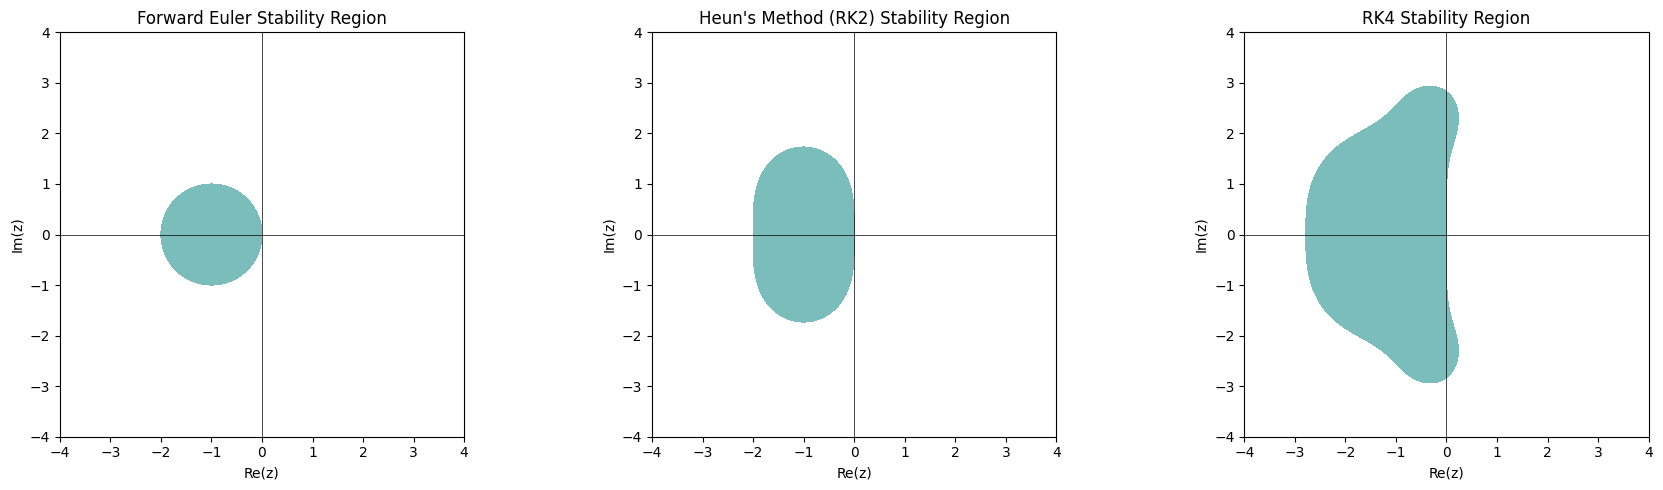

In [5]:
def R_forward_euler(z):
    return 1 + z

def R_heun(z):
# Heun's RK2: R(z) = 1 + z + z^2/2
    return 1 + z + 0.5 * z**2

def R_rk4(z):
# Classical RK4 stability polynomial
    return 1 + z + z**2/2 + z**3/6 + z**4/24

def plot_region(ax, R, title):
    # Complex grid
    re = np.linspace(-4, 4, 800)
    im = np.linspace(-4, 4, 800)
    Re, Im = np.meshgrid(re, im)
    z = Re + 1j * Im
    stability = np.abs(R(z))
    # Plot
    ax.contourf(Re, Im, stability, levels = [0, 1], alpha=0.6, cmap="viridis")
    ax.axhline(0, color="black", linewidth=0.5)
    ax.axvline(0, color="black", linewidth=0.5)
    ax.set_title(title)
    ax.set_xlabel("Re(z)")
    ax.set_ylabel("Im(z)")
    ax.set_aspect("equal")
    
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_region(axes[0], R_forward_euler, "Forward Euler Stability Region")

plot_region(axes[1], R_heun, "Heun's Method (RK2) Stability Region")
plot_region(axes[2], R_rk4, "RK4 Stability Region")
plt.tight_layout()
plt.show()

Task 3 a

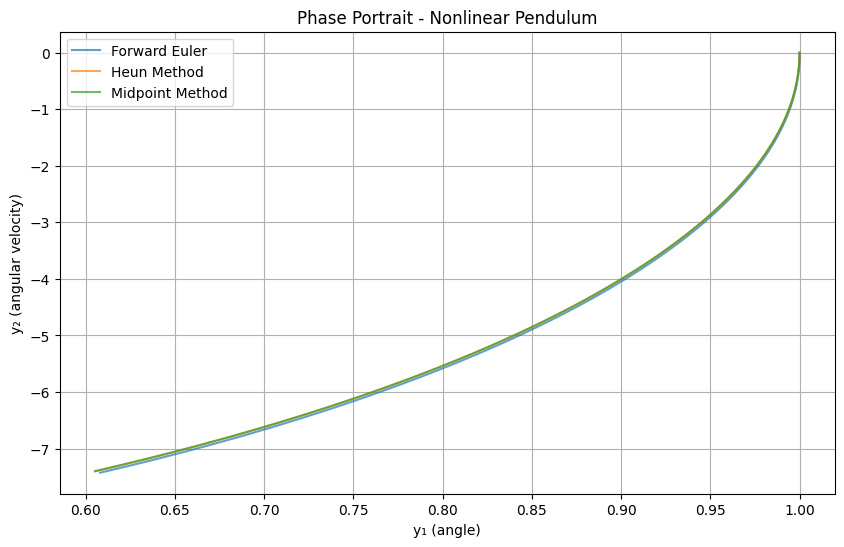

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

omega_0 = 10
xi = 0.02

def f(t, y):
    y_1 = y[0]
    y_2 = y[1]
    
    y_1_dot = y_2
    y_2_dot = -2 * xi * omega_0 * y_2 - omega_0 ** 2 * np.sin(y_1)
    
    return np.array([y_1_dot, y_2_dot])

def forward_euler_step(f, t_n, y_n, h):
    y_n1 = y_n + h * f(t_n, y_n)
    return np.array(y_n1)

def heun_step(f, t_n, y_n, h):
    k1 = f(t_n, y_n)
    k2 = f(t_n + h, y_n + h * k1)
    y_n1 = y_n + (h / 2) * (k1 + k2)
    return np.array(y_n1)

def midpoint_step(f, t_n, y_n, h):
    k1 = f(t_n, y_n)
    k2 = f(t_n + h / 2, y_n + (h / 2) * k1)
    y_n1 = y_n + h * k2
    return np.array(y_n1)

def simulate_with_method(step_func, f, y0, t0, tf, h):
    t_values = np.arange(t0, tf + h, h)
    y_values = np.zeros((len(t_values), len(y0)))
    y_values[0] = y0
    
    for n in range(len(t_values) - 1):
        y_values[n + 1] = step_func(f, t_values[n], y_values[n], h)
    
    return t_values, y_values


t0, tf = 0, 0.1
h = 0.001
ics = (1, 0)

ts_euler, sol_euler = simulate_with_method(forward_euler_step, f, ics, t0, tf, h)
ts_heun, sol_heun = simulate_with_method(heun_step, f, ics, t0, tf, h)
ts_midpt, sol_midpt = simulate_with_method(midpoint_step, f, ics, t0, tf, h)
    
# Phase portrait: y1 (angle) vs y2 (angular velocity)
plt.figure(figsize=(10, 6))
plt.plot(sol_euler[:, 0], sol_euler[:, 1], label='Forward Euler', alpha=0.7)
plt.plot(sol_heun[:, 0], sol_heun[:, 1], label='Heun Method', alpha=0.7)
plt.plot(sol_midpt[:, 0], sol_midpt[:, 1], label='Midpoint Method', alpha=0.7)

plt.xlabel('y₁ (angle)')
plt.ylabel('y₂ (angular velocity)')
plt.title('Phase Portrait - Nonlinear Pendulum')
plt.legend()
plt.grid(True)
plt.show()

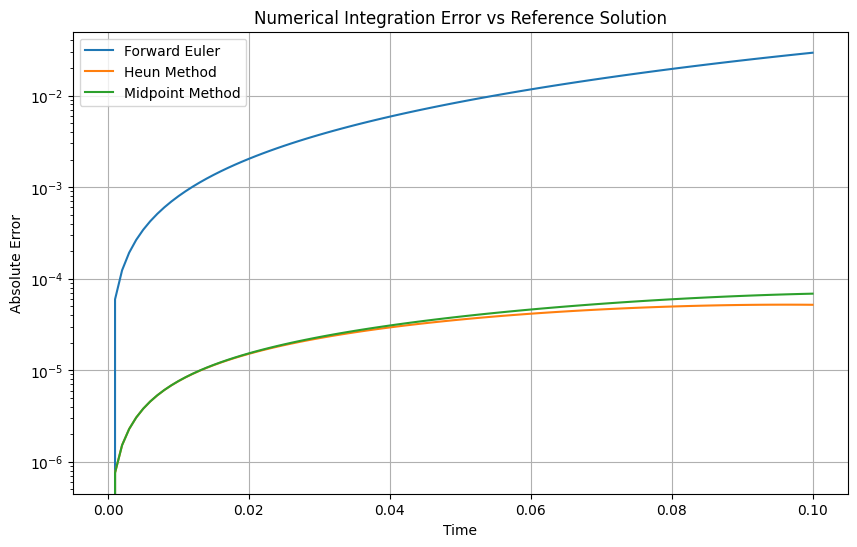

In [12]:
from scipy.integrate import solve_ivp
# we use ts_heun as the "dense output" so that we make sure the adaptive
# solve_ivp-scheme outputs times we can use to assess our solver.
ref_solution = solve_ivp(f, (t0, tf), np.array(ics), method="DOP853", atol=1e-12, rtol=1e-12, t_eval=ts_heun)

ts_solution = ref_solution.t
ys_solution = ref_solution.y.T  # Transpose to match shape (num_points, 2)

error_euler = np.sum(np.abs(ys_solution - sol_euler), axis=1)
error_heun = np.sum(np.abs(ys_solution - sol_heun), axis=1)
error_midpt = np.sum(np.abs(ys_solution - sol_midpt), axis=1)

plt.figure(figsize=(10, 6))
plt.semilogy(ts_solution, error_euler, label='Forward Euler')
plt.semilogy(ts_solution, error_heun, label='Heun Method')
plt.semilogy(ts_solution, error_midpt, label='Midpoint Method')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.title('Numerical Integration Error vs Reference Solution')
plt.legend()
plt.grid(True)
plt.show()

c)

FE EOCs: [inf, np.float64(1.0044578021225241), np.float64(1.0022513577610372), np.float64(1.0011313012363237), np.float64(1.0005670573361893)]
Heun EOCs: [inf, np.float64(2.0094754203244762), np.float64(2.004751561510276), np.float64(2.002379649349053), np.float64(2.001192508658265)]
Midpoint EOCs: [inf, np.float64(2.007706205028917), np.float64(2.0038627674282106), np.float64(2.0019341468505423), np.float64(2.000968963836967)]


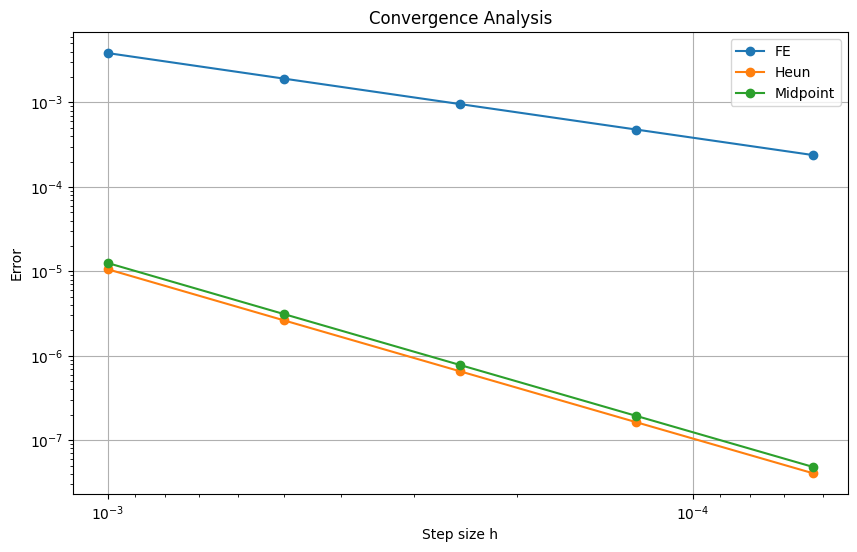

In [15]:
def compute_error(my_sol, ref_sol, h):
    return np.sqrt(np.sum(h * np.linalg.norm(np.abs(ref_sol.T - my_sol), axis=1)**2))

def compute_eoc(errors, hs):
    eocs = [np.inf]
    for i in range(1, len(errors)):
        eocs.append(np.log(errors[i-1] / errors[i]) / np.log(hs[i-1] / hs[i]))
    return eocs

def compare_stepper(t0, tf, hs, stepper, ics):
    errors = []
    for h in hs:
        _ts, _sol = simulate_with_method(stepper, f, ics, t0, tf, h)
        _ref = solve_ivp(f, (t0, _ts[-1]), np.array(ics), method="DOP853", atol=1e-12, rtol=1e-12, t_eval=_ts)
        errors.append(compute_error(_sol, _ref.y, h))
        
    eocs = compute_eoc(errors, hs)
    return errors, eocs

names = ["FE", "Heun", "Midpoint"]
steppers = [forward_euler_step, heun_step, midpoint_step]
hs = [.001 / 2**i for i in range(5)]

plt.figure(figsize=(10, 6))
for name, stepper in zip(names, steppers):
    _errs, _eocs = compare_stepper(t0, tf, hs, stepper, ics)
    print(f"{name} EOCs: {_eocs}")
    plt.loglog(hs, _errs, 'o-', label=name)

plt.gca().invert_xaxis()
plt.xlabel('Step size h')
plt.ylabel('Error')
plt.title('Convergence Analysis')
plt.legend()
plt.grid(True)
plt.show()